In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.special import expit, logit
import pandas as pd

## Data

In [23]:
#    R|RxR  L|RxR  R|RxL  L|RxL  R|LxL  L|LxL

D = [[521,   73,    61,    26,     1,    1]] # Nurhayu 2020 (Total sample parents-offspring frequency)

D = np.array(D)

## Conversion matrix 

In [10]:
def compute_T(ρ, α, β):
    """Generate T - column DD in Table 1
    
    From Appendix 3:    
    T is a 3 x 2 matrix of p(Ht | Ht x Ht) entries - 
    probability of a truly H child from a mating where parents are truly H
    """
    return np.array([
        # R           L
        [0.5 + ρ + α, 1 - (0.5 + ρ + α) ],# RxR
        [0.5 + ρ + β, 1 - (0.5 + ρ + β) ],# RxL
        [0.5 + ρ - α, 1 - (0.5 + ρ - α) ] # LxL
    ])

In [11]:
def compute_t(ρ, α, β):
    """Generate t - eq .3 - the true incidence of left-handedness
    
    From main text:
    F_DR is the final equilibrium frequency of right-handers with allele D fixed
    We need F_DL = 1 - F_DR
    """
    if β == 0:        
        FDR = (1 - 2 * α + 2 * ρ) / (2 * (1 - 2 * α)) # eq 3a
    else:
        Δ = 4 * α * α - 4 * α + 4 * β * β + 1 + 8 * β * ρ
        FDR = (2 * α + 2 * β - 1 + np.sqrt(Δ)) / (4 * β) # eq 3    
    return 1 - FDR

In [12]:
def compute_mp_mo(D):  
    assert D.ndim == 1, D.ndim
    mp = (D[2] + D[3] + 2*D[4] + 2*D[5]) / (2*D.sum())
    mo = (D[1] + D[3] + D[5]) / D.sum()
    return mp, mo

In [13]:
def compute_P(mp, t):
    """Appendix 3"""
    if mp > t:
        u = (mp - t)/mp
        assert 0 < u < 1, u
        P = np.array([
            [1, 0 ,0],
            [u, 1-u, 0],
            [u*u, 2*u*(1-u), (1-u)*(1-u)]
        ])
    else:
        v = (t - mp)/t
        assert 0 < v < 1, (v, mp, t)
        P = np.array([
            [(1-v)*(1-v), 2*v*(1-v), v*v],
            [0, 1-v, v],
            [0, 0, 1]
        ])
    return P

In [14]:
def compute_O(mo, t):
    """Appendix 3"""
    if mo > t:
        w = (mo - t)/(1-t)
        assert 0 < w < 1, w
        O = np.array([
            [1-w, w],
            [0, 1]
        ])
    else:
        x = 1 - mo/t
        assert 0 < x < 1, x
        O = np.array([
            [1, 0], 
            [x, 1-x]
        ])
    return O

In [15]:
def compute_M(T, P, O):    
    M = P @ T @ O
    return M

In [16]:
def validate(θ):
    if len(θ)==3:
        ρ, α, β = θ
    elif len(θ)==2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))
        
    if not 0 <= ρ <= 1 or not 0 <= α <= 1 or not 0 <= β <= 1 or ρ + α > 0.5 or ρ - α > 0.5 or ρ + β > 0.5:
        return False
    return True

## Likelihood function

In [17]:
def log_likelihood(θ, D):    
    D = np.atleast_2d(D)
    if len(θ)==3:
        ρ, α, β = θ
    elif len(θ)==2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))
        
    if not validate(θ):
        return -np.inf
    S = 0
    
    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0<=T) & (T<=1)).all(), θ
    assert 0 <= t <= 1, θ
    for D_ in D:
        mp, mo = compute_mp_mo(D_)
        assert 0 < mp < 1
        assert 0 < mo < 1
        P = compute_P(mp, t)
        assert ((0<=P) & (P<=1)).all()
        O = compute_O(mo, t)
        assert ((0<=O) & (O<=1)).all()
        M = compute_M(T, P, O)
        assert ((0<=M) & (M<=1)).all()
        logM = np.log(M)
        
        S += (
            D_[0] * logM[0,0] + # R|RxR
            D_[1] * logM[0,1] + # L|RxR
            D_[2] * logM[1,0] + # R|RxL
            D_[3] * logM[1,1] + # L|RxL
            D_[4] * logM[2,0] + # R|LxL
            D_[5] * logM[2,1]   # L|LxL
        )
    return S 

In [12]:
θ_1995 = np.array([0.267, 0.148,  0.012])
# θ_1995 = np.array([0.277, 0.138])
print("Laland 1995:")
print("ρ={:.3f}, α={:.3f}, β={:.3f}, logL={:.2f}".format(*θ_1995, log_likelihood(θ_1995, D)))
# print("ρ={:.3f}, α={:.2g}, logL={:.2f}".format(*θ_1995, log_likelihood(θ_1995, D)))

Laland 1995:
ρ=0.267, α=0.148, β=0.012, logL=-299.12


In [13]:
θ_19952d = np.array([0.277, 0.138])
print("Laland 1995 2D:")
print("ρ={:.3f}, α={:.2g}, logL={:.2f}".format(*θ_19952d, log_likelihood(θ_19952d, D)))

Laland 1995 2D:
ρ=0.277, α=0.14, logL=-298.17


# Maximum likelihood

In [14]:
def neg_log_likelihood(θ, D):
    return -log_likelihood(θ, D)

def fit():
    θ_hat = None
    logL = -np.inf
    for _ in range(1000):
        θ0 = np.random.random(3)/3
        result = opt.minimize(neg_log_likelihood, θ0, args=(D,), method='Nelder-Mead')
        if -result.fun > logL:
            logL = -result.fun
            θ_hat = result.x
            print(θ_hat, logL, flush=True)
    return θ_hat, logL

In [15]:
θ_mle, logL = fit()

[0.2248396  0.08481231 0.27515866] -279.8614135720677
[0.21764363 0.25271385 0.01993132] -275.80349380321644


/Users/ronykarstadt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


[0.03886442 0.45442882 0.05679544] -275.8034938024746
[0.1280711  0.35726413 0.03710153] -275.8034938023501
[0.18698745 0.2898678  0.02551311] -275.8034938022088
[0.10854841 0.37889647 0.04118846] -275.80349380217285
[0.05814651 0.43374012 0.05231205] -275.8034938021452
[0.08861017 0.40074267 0.04549951] -275.80349380214096
[0.10820288 0.37927655 0.04126615] -275.8034938021218
[0.25310556 0.20602338 0.01367238] -275.80349133715094
[0.25299306 0.20614155 0.0137339 ] -275.8034898059733


In [16]:
print("MLE estimate, logL={:.2f}".format(log_likelihood(θ_mle, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_mle))

MLE estimate, logL=-275.80
ρ=0.253, α=0.206, β=0.014


## Grid MLE

In [18]:
from concurrent.futures import ThreadPoolExecutor

In [18]:
pts = 50
ρs = np.linspace(0, 1, pts)
αs = np.linspace(0, 1, pts)
βs = np.linspace(0, 1, pts)
θs = np.array([ρs, αs, βs])
grid = np.meshgrid(ρs, αs, βs)

In [19]:
logL = np.zeros((pts, pts, pts))
futs = logL.tolist()

In [20]:
with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs[i][j][k] = pool.submit(log_likelihood, θ_, D)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [21]:
for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs[i][j][k].exception(): 
                print("Problem with", ρ_, α_, β_, ":", futs[i][j][k].exception())
                logL[i,j,k] = -np.inf
            else: 
                logL[i,j,k] = futs[i][j][k].result()

In [22]:
logL.max()

-275.8100951434045

In [23]:
i,j,k = (logL == logL.max()).nonzero()
θ_grid = ρs[i][0], αs[j][0], βs[k][0]

print("Grid MLE estimate, logL={:.2f}".format(log_likelihood(θ_grid, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_grid))

Grid MLE estimate, logL=-275.81
ρ=0.204, α=0.265, β=0.041


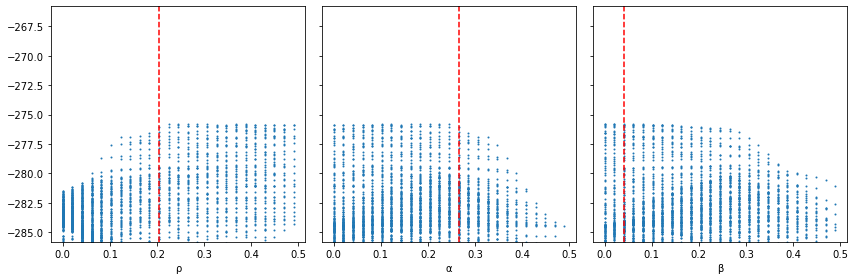

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
#     ax.axvline(θ_mle[i], color='g')
#     ax.axvline(θ_1995[i], color='k')
#     ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylim(logL.max()-10, logL.max()+10)

fig.tight_layout()

# Bayesian inference

In [19]:
import emcee
import corner

In [26]:
def log_prior(θ):
    if (θ < 0).any() or (θ>1).any():
        return -np.inf
    ρ, α, β = θ
    T = compute_T(ρ, α, β)
    if not ((0<=T) & (T<=1)).all():
        return -np.inf
    t = compute_t(ρ, α, β)
    if t < 0 or t > 1:
        return -np.inf
    return 0

log_prior(θ_1995)

0

In [20]:
def log_posterior(θ, D):
    logpri = log_prior(θ)
    if np.isinf(logpri):
        return logpri
    return logpri + log_likelihood(θ, D)

log_posterior(θ_1995, D)

NameError: name 'θ_1995' is not defined

### 3D

In [31]:
filename = "Nurhayu_3d.h5"
ndim = 3  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take
nburn = nsteps // 2  # "burn-in" period to let chains stabilize

In [ ]:
guesses = abs(np.random.normal(θ_1995, 0.01, size=(nwalkers, ndim)))
assert np.isfinite([log_prior(g) for g in guesses]).all()
assert np.isfinite([log_posterior(g, D) for g in guesses]).all()

In [24]:
# Set up the backend
# Don't forget to clear it in case the file already exists
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [30]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[D],
    backend=backend
)
sampler.run_mcmc(
    initial_state = guesses,
    nsteps=nsteps
);

In [31]:
idxmax = sampler.flatlnprobability.argmax()
θ_map = sampler.flatchain[idxmax, :]

In [40]:
reader = emcee.backends.HDFBackend(filename, read_only=True)

In [71]:
chain = reader.get_chain(discard=nsteps//2)
θ_mean = chain.mean(axis=(0,1))

In [72]:
idxmax = reader.get_log_prob(discard=nsteps//2).argmax()
θ_map = reader.get_chain(discard=nsteps//2, flat=True)[idxmax]

In [78]:
flatchain = reader.get_chain(discard=nsteps//2, flat=True)

In [93]:
ts = [compute_t(*θ_) for θ_ in flatchain]
ts = np.array(ts)

P-value: 0.018932


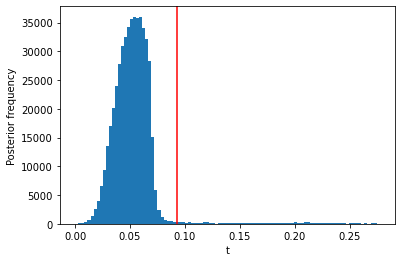

In [102]:
plt.hist(ts, bins=100)
plt.axvline(0.093216, color='r')
plt.xlabel('t')
plt.ylabel('Posterior frequency')
print("P-value:", (ts > 0.093216).mean())

In [73]:
print("Mean estimate, logL={:.2f}".format(log_likelihood(θ_mean, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_mean))

Mean estimate, logL=-275.88
ρ=0.134, α=0.334, β=0.121


In [74]:
print("MAP estimate, logL={:.2f}".format(log_likelihood(θ_map, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_map))

MAP estimate, logL=-275.80
ρ=0.096, α=0.393, β=0.043


In [33]:
print("Laland 1995, logL={:.2f}".format(log_likelihood(θ_1995, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_1995))

Laland 1995, logL=-299.12
ρ=0.267, α=0.148, β=0.012


In [34]:
idx = sampler.lnprobability > log_likelihood(θ_map, D) * 1.01
idx.shape, idx.mean()

((10, 100000), 0.912828)

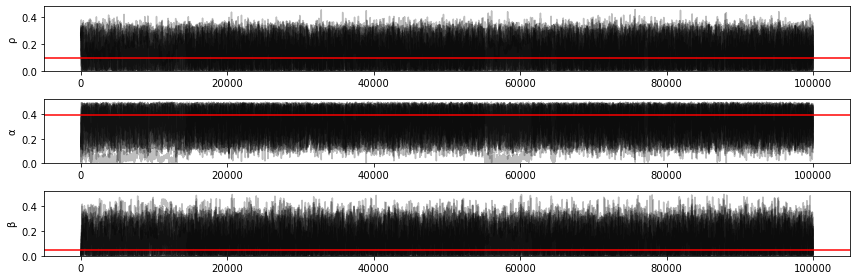

In [35]:
fig, axes = plt.subplots(ndim, 1, figsize=(12, 4))
labels = 'ρ α β'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25)
    ax.axhline(θ_map[i], color='r')
    ax.set_ylabel(labels[i])
    ax.set_ylim(0, None)
fig.tight_layout()

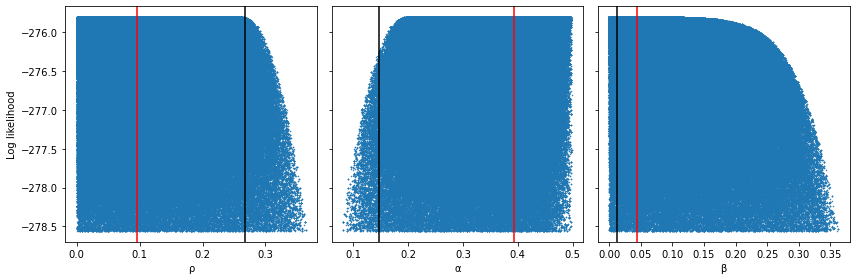

In [55]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
#     ax.axvline(θ_mle[i], color='g')
    ax.axvline(θ_1995[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
fig.tight_layout()

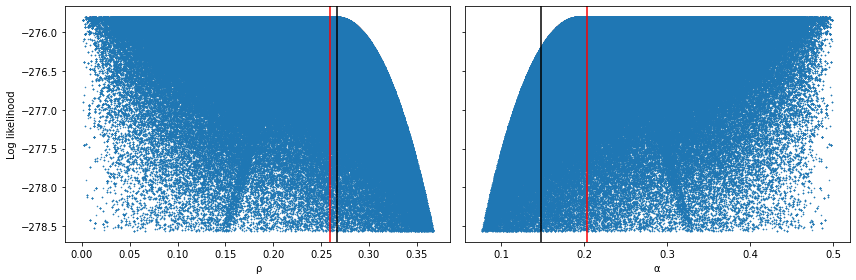

In [81]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
#     ax.axvline(θ_mle[i], color='g')
    ax.axvline(θ_1995[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
#axes[0].set_ylim(-299.12,-275.80)
fig.tight_layout()

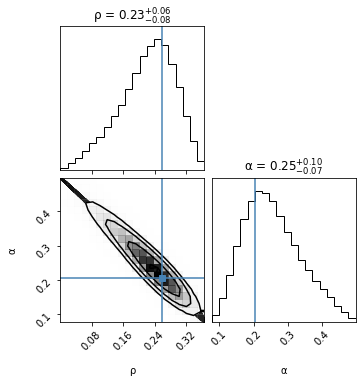

In [82]:
cor = corner.corner(
    sampler.flatchain[idx], 
    smooth=True,
    labels=labels,
    show_titles=True,
    truths=θ_map
)

### 2D

In [83]:
def log_prior(θ):
    if (θ < 0).any() or (θ>1).any():
        return -np.inf
    ρ, α = θ
    β = 0
    T = compute_T(ρ, α, β)
    if not ((0<=T) & (T<=1)).all():
        return -np.inf
    t = compute_t(ρ, α, β)
    if t < 0 or t > 1:
        return -np.inf
    return 0

In [84]:
ndim = 2  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take
nburn = nsteps // 2  # "burn-in" period to let chains stabilize

guesses = abs(np.random.normal(θ_1995[:2], 0.01, size=(nwalkers, ndim)))
assert np.isfinite([log_prior(g) for g in guesses]).all()
assert np.isfinite([log_posterior(g, D) for g in guesses]).all()

In [85]:
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "Nurhayu_2d.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [86]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[D],
    backend=backend
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
);

In [87]:
idxmax = sampler.flatlnprobability.argmax()
θ_map = sampler.flatchain[idxmax, :]

In [88]:
print("MAP estimate, logL={:.2f}".format(log_likelihood(θ_map, D)))
print("ρ={:.3f}, α={:.3f}".format(*θ_map))

MAP estimate, logL=-275.81
ρ=0.266, α=0.193


In [89]:
idx = sampler.lnprobability > log_likelihood(θ_map, D) * 1.01
idx.shape, idx.mean()

((10, 100000), 0.955644)

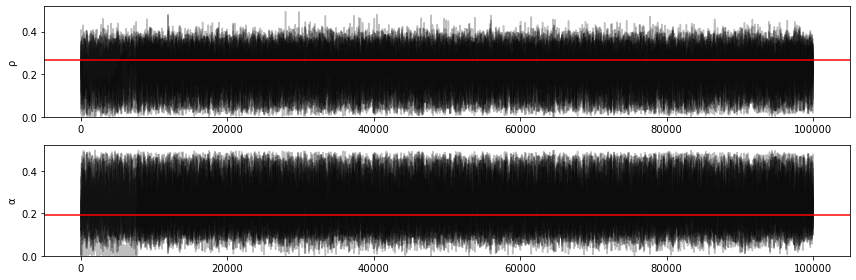

In [90]:
fig, axes = plt.subplots(ndim, 1, figsize=(12, 4))
labels = 'ρ α'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25)
    ax.axhline(θ_map[i], color='r')
    ax.set_ylabel(labels[i])
    ax.set_ylim(0, None)
fig.tight_layout()

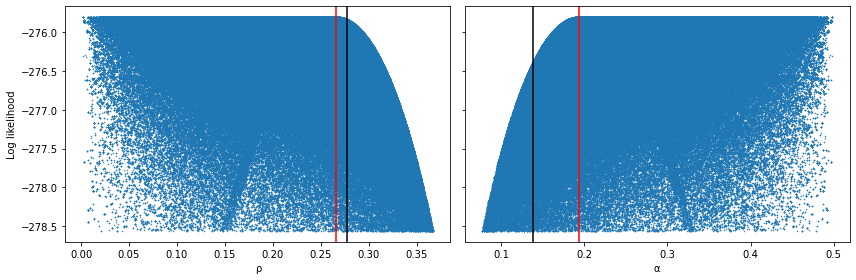

In [91]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
    ax.axvline(θ_19952d[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
fig.tight_layout()

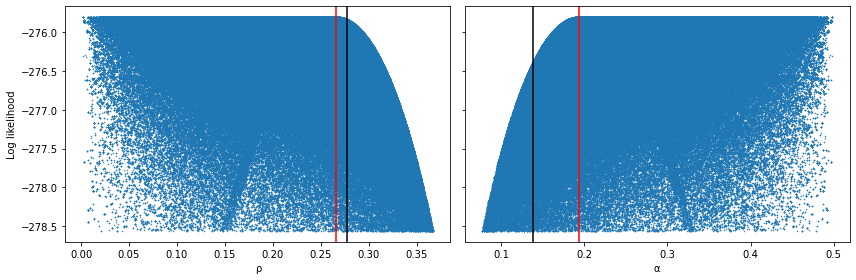

In [92]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
    ax.axvline(θ_19952d[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
#axes[0].set_ylim(-278.5, -276)
fig.tight_layout()

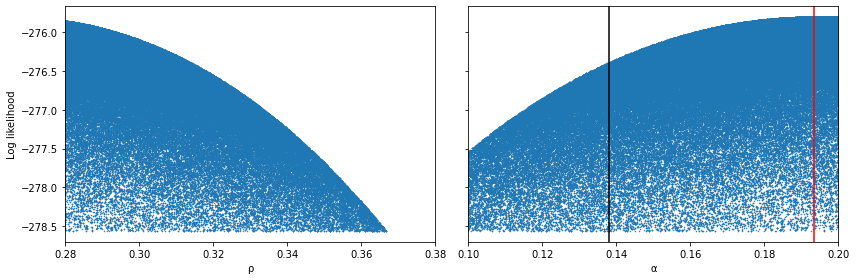

In [93]:
idx = sampler.flatlnprobability > log_likelihood(θ_map, D) * 1.01
samples = sampler.flatchain[idx]
logL = sampler.flatlnprobability[idx]

fig, axes = plt.subplots(1, ndim, figsize=(12, 4), sharey=True)
labels = 'ρ α'.split()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], logL, '.', markersize=1)
    ax.axvline(θ_map[i], color='r')
    ax.axvline(θ_19952d[i], color='k')
    ax.set_xlabel(labels[i])
axes[0].set_ylabel('Log likelihood')
#axes[0].set_ylim(-8610, -8604)
axes[0].set_xlim(0.28, 0.38)
axes[1].set_xlim(0.1, 0.2)
fig.tight_layout()

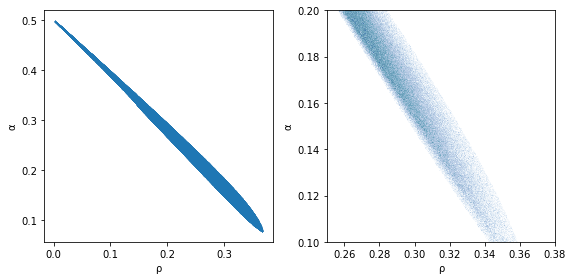

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
ax = axes[0]
ax.plot(samples[:, 0], samples[:, 1], '.', markersize=1, alpha=0.3)
ax.set_xlabel('ρ')
ax.set_ylabel('α')

ax = axes[1]
ax.plot(samples[:, 0], samples[:, 1], ',', alpha=0.01)
ax.set_xlabel('ρ')
ax.set_ylabel('α')
ax.set(xlim=(0.25, 0.38), ylim=(0.1, 0.2));

fig.tight_layout()

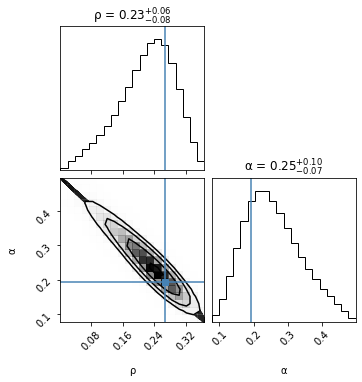

In [95]:
cor = corner.corner(
    sampler.flatchain[idx], 
    smooth=True,
    labels=labels,
    show_titles=True,
    truths=θ_map
)